# Lab 4: Comparison of Binary Classifiers

#### Name:  Paul Trayers
#### Student ID:  8907021

# Task 2

Train and evaluate classifier (binary) with the wheat kernels dataset [described here](https://archive.ics.uci.edu/ml/datasets/seeds) having dependent variable `type`. 

Summarise conclusions in 200 words.
* Formulate and justify binary classification problem.
* Discuss the cost of misclassifying examples.
* Identify the best classifier.
* Parameters exploration.


# 1. Introduction

## 1.1 Problem Statement
### 1.1.1 Background
The samples were collected in the Abovyan region of Armenia in 1930, the data set is available from the UCI Machine Learning Repository. The data set contains 70 samples from each of three varieties of wheat (Kama, Rosa, and Canadian) indicated by `type`.  

#### Features
- area $A$
- perimeter $P$
- compactness $C = 4piA/P^2$
- length of kernel
- width of kernel
- asymmetry coefficient
- length of kernel groove

#### Classification
- Kama : 1
- Not Kama (Canadian and Rosa) : 0

### 1.1.2 Justification
Framing the problem as a binary classification task, we can use supervised learning techniques to develop a model that can predict the type of wheat kernel based on its physical properties. This can have practical applications in the food production industry, where it may be important to quickly and accurately classify wheat kernels for quality assurance purposes.

### 1.1.3 Problem Statement
The chosen goal is to classify the Kama kernel variety for purposes of quality control in a food production plant creating products for health food market targeting consumers who may have specific allergies to certain wheat types. Knowing the specific type of wheat kernel used in a product can be important for people with wheat allergies. 

Therefore we wish to classify Kama variety (`type`=2) distinct from the other two varieties. The goal is to develop a classification algorithm to distinguish between different types of wheat kernels based on their physical properties, with `type` as the dependent variable.

### 1.1.4 Mis-classification Cost
In this context the cost of mis-classification is high potentially resulting in consumer medical impacts the consequent effects of which might include product recall, reputational damage, regulatory breach and legal liability.  For these reasons the Precision metric is most crticial in order to minimise the rate of false postives (FPR) in validating whether seeds are Kama variety (+ve).


## 1.2 Load Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("./seeds.csv")

## 1.3 EDA

In [3]:
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [4]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [5]:
# Check the distribution of values for the dependent variable 
#
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

Check for missing values..

In [6]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. Next check boxplot for outliers..

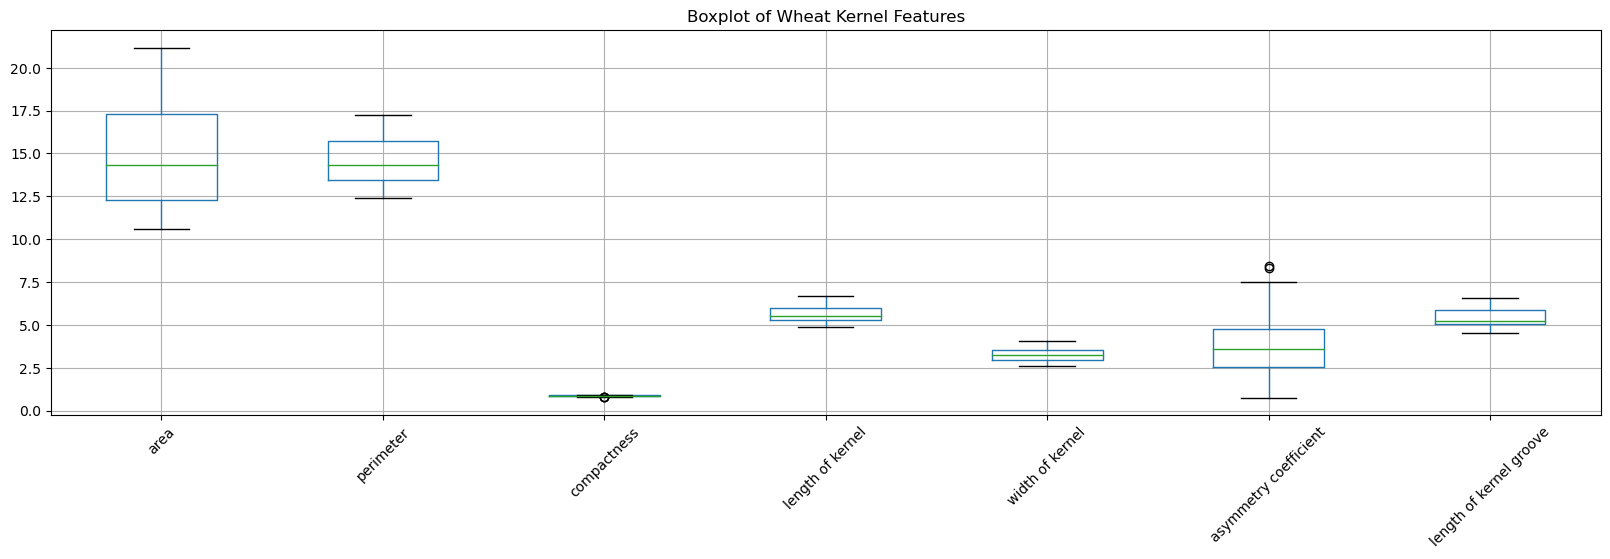

In [7]:

# Boxplot of all input variables
#
df_features = df.loc[:,'area':'length of kernel groove']
df_features.boxplot(figsize=(20,5))  # Pandas dataframe boxplot
plt.title("Boxplot of Wheat Kernel Features")
plt.xticks(range(1, len(df_features.columns) + 1), df_features.columns, rotation=45)
plt.show()

* `compactness` and `asymmetry coefficient` have outliers but are dimensionless so already on a standard scale. 
  * (Arguably, we could instead apply log transformation followed by `RobustScaler` being less sensitive to outliers than other scalers like MinMaxScaler or StandardScaler)
* `area` $(m^2)$ has different scale than `perimeter` and the other measures of length $(m)$ so should be re-scaled. To avoid having features on different scales potentially impacting the model we will rescale all to same range using `StandardScaler` since none of the other columns appear to contain outliers.  

Plot feature histograms..

In [50]:
import seaborn as sns

plt.figure(figsize=(20,60), facecolor='white')

plotnumber = 1
for col in df_features.columns:
    ax = plt.subplot(12,3,plotnumber)
    sns.histplot(df_features[col], kde=True)

    plt.xlabel(col)
    plotnumber += 1

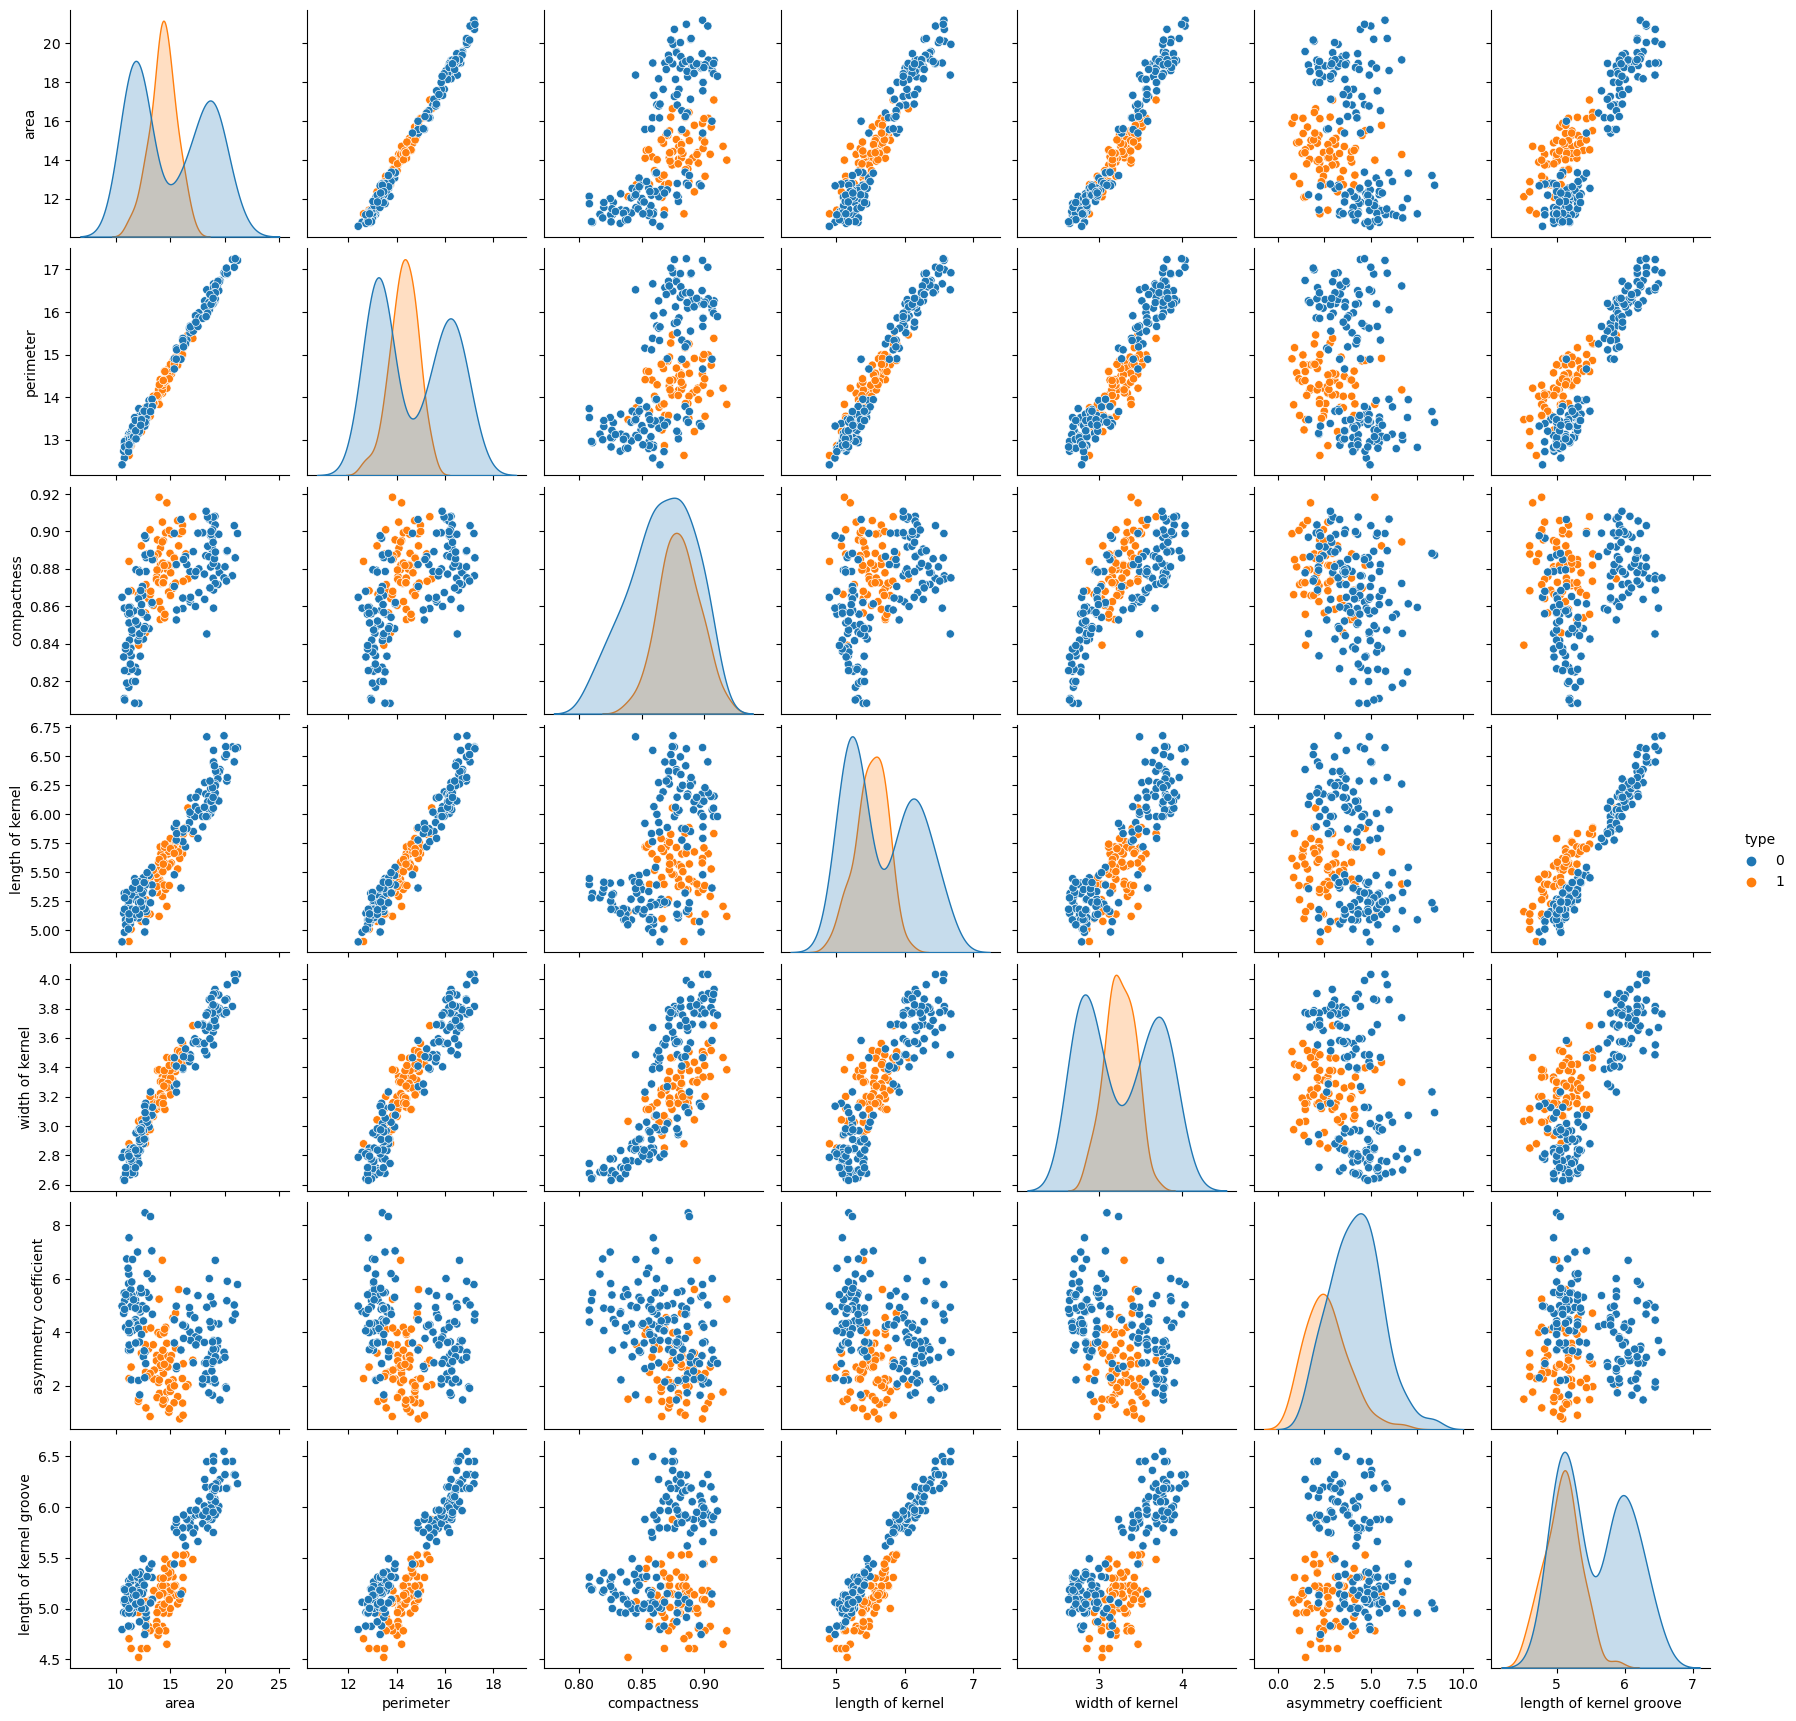

In [51]:
# Examinations of groups
sns.pairplot(df, hue="type")

### 1.3.1 EDA Observations

In [8]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient', 'compactness']
names_no_outliers = list(set(names_all) - set(names_outliers))

## 1.4 Data Prep
### 1.4.1 Binary mapping

Map `type` values based on the binary classification problem statement above. 

In [58]:
# transform the type column, 1 for type 2 and 0 for other types
df['type'] = df['type'].apply(lambda x: 1 if x == 1 else 0)

Show the updated distribution of `type` following mapping..

In [11]:
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

### 1.4.2 Create Pipeline

Add helper classes..
After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to add the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns.

In [12]:
# Add columns (that were previously removed) back into the data 
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)
    
# Select group of columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Build preprocessing pipeline, adding the column names back to the example set and applying two different data preparation strategies to the two groups of columns joining with `FeatureUnion` - log and RobustScaler to outliers and StandardScaler otherwise.

In [13]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers)#,
            #FunctionTransformer(np.log, validate=True),
            #RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

### 1.4.3 Split Training / Test set
Split the dataset and test set 80:20...

In [14]:
# Split the dataset into features and target
X = df.drop('type', axis=1).values
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    stratify=y)  # ensures all classes of dependent variable are represented in the same proportion in training and test sets.


## 2. SVM classifier
### 2.1 Pipeline with Grid Search
Train an SVM classifier with the training set and range of possible parameters to find the best parameters by cross-validation.  Build a pipeline to include the preprocessing pipeline and SVM classifier.  This _separately_ preprocesses the training and validation sets _after_ the training set is further split into training and validation sets in the process of cross-validation.

In [15]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

svm_search = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=-1, 
                      cv=5,       # k-fold cross-validation
                      refit=True) # makes GridSearchCV train an SVM classifier on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.
svm_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % svm_search.best_score_)
print("Best parameters: ", svm_search.best_params_)

# store the best params and best model for later use
SVM_best_params = svm_search.best_params_
SVM_best_model = svm_search.best_estimator_

Best CV score = 0.947:
Best parameters:  {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'poly'}


## 3. Random Forest classifier
### 3.1 Pipeline with Grid Search
* Train RF classifier with training set and range of parameters to find best parameters by cross-validation. 
* Build pipeline with preprocessing pipeline and RF classifier.
  * Separately preprocess training and validation sets _after_ training set further split into training and validation sets as part of cross-validation.

In [16]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [5, 10, 15, 20, 30],
    'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8]
}

rf_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
rf_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % rf_search.best_score_)
print("Best parameters: ", rf_search.best_params_)

# store the best params and best model for later use
RF_best_params = rf_search.best_params_
RF_best_model = rf_search.best_estimator_

Best CV score = 0.935:
Best parameters:  {'rf__max_depth': 5, 'rf__n_estimators': 15}


## 4. Evaluation

### 4.1 Background

Evaluate best models found by the grid search on the test dataset comparing results to choose the better classifier for our problem.

First we need to map the outputs of the classification into one of the following categories;
* TRUE POSITIVE (TP): A _Kama_ seed that is Type 1 (originally type 2) and classified as Kama (POSITIVE).
* TRUE NEGATIVE (TN): A non-_Kama_ seed that is Type 0 (originally type 1 or 3) and classified as NOT Kama (NEGATIVE).
* FALSE POSITIVE (FP): A non-_Kama_ seed that is Type 0 (originally type 1 or 3) but classified as Kama (POSITIVE).
* FALSE NEGATIVE (FN): A Kama_ seed that is Type 1 (originally type 2) but classified as NOT Kama (NEGATIVE).

We are aiming for TPs and TNs but through misclassification of the model may end up with some proportion of FPs and FNs.

* *Accuracy*: Represents number of correctly classified data instances over the total number of data instances.
  * $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
  
  Accuracy is not a good measure here since the dataset is unbalanced i.e. negative (140) and positive classes (70) have different number of data instances. For example, assuming the algorithm classified all seeds as the non-Kama (-ve) then our accuracy would be $\frac{0 + 140}{0 + 140 + 0 + 70} = 66.7%$. This case shows ~67% accuracy although the model is very poor because all 70 Kama seeds are classified incorrectly, showing that using accuracy here can result in misleading interpretation of results.
  
* *Precision*: Positive predictive value.
 
  * $Precision = \frac{TP}{TP + FP}$
  
  High for a good classifier. Being 1 indicates there are zero FPs. 

* *Recall*: True Positive rate (Sensitivity)

  * $Recall = \frac{TP}{TP + FN}$
  
  High for a good classifier. Being 1 indicates there are zero FNs. 

* *F1-score*: _Harmonic mean_ of Precision and Recall

  * $F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$

  Becomes high only when both precision and recall are high and is a better measure than accuracy, especially for imbalanced dataset.

### 4.2 Metrics Measurement 

Obtain metrics for both models and compare.

In [17]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [18]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1
def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictions for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Execute the model $n$ times to obtain average values.

In [19]:
def execute_model(model, X, y, name, n_times=10):

    # Initialize the lists to store the evaluation metrics for each run
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    tpr_list = []
    auc_list = []

    best_model = None
    best_score = -np.inf
    best_params = None

    for i in range(n_times):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

        model.fit(X_train, y_train) 
        
        score = model.best_score_
        if score > best_score:
            best_params = model.best_params_
            best_score = score

            best_model = model.best_estimator_

        accuracy, precision, recall, f1_score, tpr, auc = evaluate_model(X_test, y_test, model.best_estimator_)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        tpr_list.append(tpr)
        auc_list.append(auc)
    
    print(f"\nResults for {name} model ({n_times} runs):")
    print("Best CV score = %0.3f:" % model.best_score_)
    print("Best parameters: ", model.best_params_)

    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1_score = np.mean(f1_score_list)
    avg_tpr = np.mean(tpr_list, axis=0)
    avg_auc = np.mean(auc_list)

    # print in tabular form later..
    #print(f"Mean", name, f" Accuracy: {avg_accuracy:.2f}")
    #print(f"Mean", name, f" Precision: {avg_precision:.2f}")
    #print(f"Mean", name, f" Recall: {avg_recall:.2f}")
    #print(f"Mean", name, f" F1-score: {avg_f1_score:.2f}")

    return avg_accuracy, avg_precision, avg_recall, avg_f1_score, avg_tpr, avg_auc, best_params


In [20]:
n_times = 10

mean_SVM_accuracy, mean_SVM_precision, mean_SVM_recall, mean_SVM_f1_score, mean_SVM_tpr, mean_SVM_auc, svm_best_params = execute_model(svm_search, X, y, "SVM", n_times)

mean_RF_accuracy, mean_RF_precision, mean_RF_recall, mean_RF_f1_score, mean_RF_tpr, mean_RF_auc, rf_best_params = execute_model(rf_search, X, y, "RF", n_times)


Results for SVM model (10 runs):
Best CV score = 0.965:
Best parameters:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}

Results for RF model (10 runs):
Best CV score = 0.946:
Best parameters:  {'rf__max_depth': 5, 'rf__n_estimators': 5}


Print metrics average scores...

In [21]:
from tabulate import tabulate

headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
data = [
    ['SVM', f'{mean_SVM_accuracy:.3f}', f'{mean_SVM_precision:.3f}', f'{mean_SVM_recall:.3f}', f'{mean_SVM_f1_score:.3f}'],
    ['Random Forest', f'{mean_RF_accuracy:.3f}', f'{mean_RF_precision:.3f}', f'{mean_RF_recall:.3f}', f'{mean_RF_f1_score:.3f}']
]
print(f"Mean results from {n_times} runs:\n")
print(tabulate(data, headers=headers))

Mean results from 10 runs:

Model            Accuracy    Precision    Recall    F1-Score
-------------  ----------  -----------  --------  ----------
SVM                 0.976        1         0.929       0.963
Random Forest       0.94         0.985     0.836       0.902


Plot metrics for model comparison...

In [22]:
SVM_metrics = np.array([mean_SVM_accuracy, mean_SVM_precision, mean_SVM_recall, mean_SVM_f1_score])
RF_metrics = np.array([mean_RF_accuracy, mean_RF_precision, mean_RF_recall, mean_RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.title(f"Mean metrics for SVM and Random Forest ({n_times} runs)")
plt.legend(loc="lower right")
plt.show()

Plot ROC curves for comparison...

In [23]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, mean_SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (mean_SVM_auc), alpha=0.8)
plt.plot(mean_fpr, mean_RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (mean_RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

### 4.2.1 Train Final Model
Finally, we can train an SVM model with *all* data we have, since the _more_ data we have the better the model.

In [95]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(svm_best_params)))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [96]:
filename = 'task2_final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## 5. Analysis and Conclusion

#### Metric Scores
Since per problem statement there is high cost associated with false negatives, Precision is be a more important metric to consider than Recall. This is because a false positive means that a potentially different kernel type was allowed to be introduced in the product, which could lead to product recall or even lawsuit, so we would prefer a model with higher precision, even if it means sacrificing some recall.

In our results, the SVM model had a higher precision than the random forest model (1 vs 0.983), indicating that it is better at minimizing false positives. Therefore, if there is a high cost associated with false positives, we may prefer the SVM model over the random forest model.

#### ROC Curve
The ROC curve indicates the trade-off between the TPR and FPR, given we want to select a model with high TPR and low FPR that can effectively distinguish between positive and negative samples. The curve is also summarized by the AUC (Area Under the Curve) metric representing probability that a positive sample is ranked higher than negative samples.

The ROC curves confirm that both classifiers perform significantly better than a random guess (the red dashed line).
However, we can observe the SVM curve as a perfect classifier with an AUC of 1.0. Random Forest by comparison has AUC 0.98 with the curve below 1 until the threshold reaches 0.4 - if we were to use RF we would need to adjust the threshold to increase the sensitivity of the model to minimize FPs. (as a comparison, if we wanted to minimize waste by minimizing false negatives FNs we would instead plot an SROC curve to examine _specificity_.

 We will pick SVM to train a final model on the whole dataset.

# Task 3
Train a third classifier (e.g., MLPClassifier, Naive Bayes, kNN) with seeds.csv add compare it to both SVM and Random Forest. Summarise your experience with exploring the parameters in 150 words.

## 6. MLP classifier

In [45]:
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('scaler', StandardScaler()),
                       ('mlp', MLPClassifier())])

# prepare a parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__max_iter': [1000],   # [100, 200, 300, 400]
    'mlp__learning_rate_init': [0.001, 0.01, 0.1]
}

mlp_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
# Filter out convergence warnings
# Suppress ConvergenceWarning warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    mlp_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % mlp_search.best_score_)
print("Best parameters: ", mlp_search.best_params_)

# store the best params and best model for later use
MLP_best_params = mlp_search.best_params_
MLP_best_model = mlp_search.best_estimator_


Best CV score = 0.953:
Best parameters:  {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 1000}


# 7. Naive Bayes classifier

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('scaler', StandardScaler()),
                       ('nb', GaussianNB())])

# prepare a parameter grid
#param_grid = {}
param_grid = {'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

nb_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
nb_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % nb_search.best_score_)
print("Best parameters: ", nb_search.best_params_)

# store the best model for later use
NB_best_model = nb_search.best_estimator_


Best CV score = 0.863:
Best parameters:  {'nb__var_smoothing': 1e-09}


# 8. kNN classifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('scaler', StandardScaler()),
                       ('knn', KNeighborsClassifier())])

# prepare a parameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

knn_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
knn_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % knn_search.best_score_)
print("Best parameters: ", knn_search.best_params_)

# store the best model for later use
kNN_best_model = knn_search.best_estimator_


Best CV score = 0.929:
Best parameters:  {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}


# 9. Decision Trees
Decision Trees are a simple yet effective type of classifier that work by recursively splitting the data based on the value of different features. Decision trees can handle both numerical and categorical data and can be interpreted easily, making them useful for generating insights and understanding the decision-making process.


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('dt', DecisionTreeClassifier())])

# prepare a parameter grid
param_grid = {
    'dt__max_depth': [None, 5, 10],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}

dt_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
dt_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % dt_search.best_score_)
print("Best parameters: ", dt_search.best_params_)

# store the best model for later use
DT_best_model = dt_search.best_estimator_


Best CV score = 0.905:
Best parameters:  {'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2}


# 10. Gradient Boosting Machines

Gradient Boosting Machines (GBMs): GBMs are an ensemble of decision trees that work by sequentially fitting new trees to the residual errors of the previous trees. GBMs can handle both numerical and categorical data and can achieve high accuracy by combining the strengths of multiple weak learners.

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('gb', GradientBoostingClassifier())])

# prepare a parameter grid
param_grid = {
    'gb__learning_rate': [0.1, 0.01],
    'gb__n_estimators': [50, 100, 200],
    'gb__max_depth': [3, 5, 7],
    'gb__min_samples_split': [2, 5, 10],
    'gb__min_samples_leaf': [1, 2, 4],
}

gbm_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
gbm_search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % gbm_search.best_score_)
print("Best parameters: ", gbm_search.best_params_)

# store the best model for later use
GB_best_model = gbm_search.best_estimator_


Best CV score = 0.929:
Best parameters:  {'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__min_samples_leaf': 4, 'gb__min_samples_split': 5, 'gb__n_estimators': 50}


# 11. Logistic Regression classifier
Logistic regression is a statistical method used for binary classification problems, where the goal is to predict the probability of an input belonging to one of two possible classes. It works by modeling the logarithm of the odds of an input belonging to a certain class as a linear function of the input features, and then applying a logistic (sigmoid) function to this linear function to obtain the predicted probability. Logistic regression is a simple yet powerful algorithm that is widely used in various fields, such as machine learning, statistics, and social sciences.

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))])

# prepare a parameter grid
param_grid = {'logreg__penalty': ['l1', 'l2'],
              'logreg__C': [0.01, 0.1, 1, 10, 100]}

logreg_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True, error_score='raise')
logreg_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % logreg_search.best_score_)
print("Best parameters: ", logreg_search.best_params_)

# store the best model for later use
logreg_best_model = logreg_search.best_estimator_


Best CV score = 0.946:
Best parameters:  {'logreg__C': 100, 'logreg__penalty': 'l1'}


## 11. Metrics Measurement

In [46]:
n_times = 10

# MLP
mlp = MLPClassifier()
param_grid_mlp = {
    'hidden_layer_sizes': [(32, 32), (64, 64), (128, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.001, 0.0001]
}
mean_MLP_accuracy, mean_MLP_precision, mean_MLP_recall, mean_MLP_f1_score, mean_MLP_tpr, mean_MLP_auc, mlp_best_params = execute_model(mlp_search, X, y, "MLP", n_times)

# Naive Bayes
mean_NB_accuracy, mean_NB_precision, mean_NB_recall, mean_NB_f1_score, mean_NB_tpr, mean_NB_auc, nb_best_params = execute_model(nb_search, X, y, "Naive Bayes", n_times)


Results for MLP model (10 runs):
Best CV score = 0.947:
Best parameters:  {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate_init': 0.1, 'mlp__max_iter': 1000}

Results for Naive Bayes model (10 runs):
Best CV score = 0.869:
Best parameters:  {'nb__var_smoothing': 1e-09}


In [93]:
# KNN
mean_KNN_accuracy, mean_KNN_precision, mean_KNN_recall, mean_KNN_f1_score, mean_KNN_tpr, mean_KNN_auc, knn_best_params = execute_model(knn_search, X, y, "KNN", n_times)

# Decision Tree
mean_DT_accuracy, mean_DT_precision, mean_DT_recall, mean_DT_f1_score, mean_DT_tpr, mean_DT_auc, dt_best_params = execute_model(dt_search, X, y, "Decision Tree", n_times)

# Gradient Boosting
mean_GBM_accuracy, mean_GBM_precision, mean_GBM_recall, mean_GBM_f1_score, mean_GBM_tpr, mean_GBM_auc, gbm_best_params = execute_model(gbm_search, X, y, "Gradient Boosting", n_times)

# Logistic Regression
mean_LR_accuracy, mean_LR_precision, mean_LR_recall, mean_LR_f1_score, mean_LR_tpr, mean_LR_auc, lr_best_params = execute_model(logreg_search, X, y, "Logistic Regression", n_times)


Results for KNN model (10 runs):
Best CV score = 0.934:
Best parameters:  {'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}

Results for Decision Tree model (10 runs):
Best CV score = 0.928:
Best parameters:  {'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}

Results for Gradient Boosting model (10 runs):
Best CV score = 0.940:
Best parameters:  {'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 2, 'gb__n_estimators': 200}

Results for Logistic Regression model (10 runs):
Best CV score = 0.935:
Best parameters:  {'logreg__C': 1, 'logreg__penalty': 'l1'}


Collate and print average score metrics...

In [94]:
from tabulate import tabulate

headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
data = [
    ['SVM', f'{mean_SVM_accuracy:.3f}', f'{mean_SVM_precision:.3f}', f'{mean_SVM_recall:.3f}', f'{mean_SVM_f1_score:.3f}'],
    ['Random Forest', f'{mean_RF_accuracy:.3f}', f'{mean_RF_precision:.3f}', f'{mean_RF_recall:.3f}', f'{mean_RF_f1_score:.3f}'],
    ['Neural Network', f'{mean_MLP_accuracy:.3f}', f'{mean_MLP_precision:.3f}', f'{mean_MLP_recall:.3f}', f'{mean_MLP_f1_score:.3f}'],
    ['Naive Bayes', f'{mean_NB_accuracy:.3f}', f'{mean_NB_precision:.3f}', f'{mean_NB_recall:.3f}', f'{mean_NB_f1_score:.3f}'],
    ['kNN', f'{mean_KNN_accuracy:.3f}', f'{mean_KNN_precision:.3f}', f'{mean_KNN_recall:.3f}', f'{mean_KNN_f1_score:.3f}'],
    ['Decision Tree', f'{mean_DT_accuracy:.3f}', f'{mean_DT_precision:.3f}', f'{mean_DT_recall:.3f}', f'{mean_DT_f1_score:.3f}'],
    ['Gradient Boost', f'{mean_GBM_accuracy:.3f}', f'{mean_GBM_precision:.3f}', f'{mean_GBM_recall:.3f}', f'{mean_GBM_f1_score:.3f}'],
    ['Logistic Regression', f'{mean_LR_accuracy:.3f}', f'{mean_LR_precision:.3f}', f'{mean_LR_recall:.3f}', f'{mean_LR_f1_score:.3f}'],
]
# Sort the data by F1-score (column index 4)
data_sorted = sorted(data, key=lambda x: x[4], reverse=True)

print(f"Mean results from {n_times} runs, ordered by F1-score:\n")
print(tabulate(data_sorted, headers=headers))

Mean results from 10 runs, ordered by F1-score:

Model                  Accuracy    Precision    Recall    F1-Score
-------------------  ----------  -----------  --------  ----------
SVM                       0.976        1         0.929       0.963
Neural Network            0.974        1         0.921       0.959
kNN                       0.952        1         0.857       0.923
Logistic Regression       0.952        1         0.857       0.923
Random Forest             0.94         0.985     0.836       0.902
Naive Bayes               0.929        0.923     0.857       0.889
Gradient Boost            0.905        1         0.714       0.833
Decision Tree             0.879        0.914     0.7         0.788


Plot metrics for model comparison...

In [69]:
SVM_metrics = np.array([mean_SVM_accuracy, mean_SVM_precision, mean_SVM_recall, mean_SVM_f1_score])
RF_metrics = np.array([mean_RF_accuracy, mean_RF_precision, mean_RF_recall, mean_RF_f1_score])
MLP_metrics = np.array([mean_MLP_accuracy, mean_MLP_precision, mean_MLP_recall, mean_MLP_f1_score])
NB_metrics = np.array([mean_NB_accuracy, mean_NB_precision, mean_NB_recall, mean_NB_f1_score])
KNN_metrics = np.array([mean_KNN_accuracy, mean_KNN_precision, mean_KNN_recall, mean_KNN_f1_score])
DT_metrics = np.array([mean_DT_accuracy, mean_DT_precision, mean_DT_recall, mean_DT_f1_score])
GBM_metrics = np.array([mean_GBM_accuracy, mean_GBM_precision, mean_GBM_recall, mean_GBM_f1_score])
LR_metrics = np.array([mean_LR_accuracy, mean_LR_precision, mean_LR_recall, mean_LR_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({ 'SVM': SVM_metrics, 
                            'Random Forest': RF_metrics,
                            'Neural Network': MLP_metrics,
                            'Naive Bayes': NB_metrics,
                            'kNN': KNN_metrics,
                            'Decision Tree': DT_metrics,
                            'Gradient Boost': GBM_metrics,
                            'Logistic Regression': LR_metrics
                           }, index=index)
df_metrics.plot.bar(rot=0)
plt.title(f"Mean metrics for multiple classifiers ({n_times} runs)")
plt.legend(loc="lower right")
plt.show()

Plot ROC curves for comparison...

In [70]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, mean_SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (mean_SVM_auc), alpha=0.8)
plt.plot(mean_fpr, mean_RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (mean_RF_auc), alpha=0.8)
plt.plot(mean_fpr, mean_MLP_tpr[0,:], lw=2, color='green', label='Neural Network (AUC = %0.2f)' % (mean_MLP_auc), alpha=0.8)
plt.plot(mean_fpr, mean_NB_tpr[0,:], lw=2, color='red', label='Naive Bayes (AUC = %0.2f)' % (mean_NB_auc), alpha=0.8)
plt.plot(mean_fpr, mean_KNN_tpr[0,:], lw=2, color='purple', label='kNN (AUC = %0.2f)' % (mean_KNN_auc), alpha=0.8)
plt.plot(mean_fpr, mean_DT_tpr[0,:], lw=2, color='brown', label='Decision Tree (AUC = %0.2f)' % (mean_DT_auc), alpha=0.8)
plt.plot(mean_fpr, mean_GBM_tpr[0,:], lw=2, color='pink', label='Gradient Boost (AUC = %0.2f)' % (mean_GBM_auc), alpha=0.8)
plt.plot(mean_fpr, mean_LR_tpr[0,:], lw=2, color='gray', label='Logistic Regression (AUC = %0.2f)' % (mean_LR_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

### 11.1 Analysis and Conclusion

Based on the evaluation metrics, the SVM and Neural Network models are the best-performing models, achieving the highest accuracy and precision among all the models. The kNN and Logistic Regression models also achieve high accuracy and precision, but their recall and F1-score are lower than the top two models.

The Random Forest and Naive Bayes models achieved moderate accuracy and precision, but their recall and F1-score are lower than the top two models. The Gradient Boost and Decision Tree models continue to have the lowest accuracy and precision among all the models, and their recall and F1-score also remain relatively lower than the top-performing models.

The ROC curves diagram indicates SVM and kNN and MLP with the highest AUCs of 1.0 having the best overall performance. All have a curve that approaches the upper left corner of the plot, indicating high true positive rate and low false positive rate. 

Overall, the SVM model achieved the best performance based on the given evaluation metrics. However, it's important to note that the choice of the best model may also depend on other factors such as computational complexity, interpretability, and class imbalance. Therefore, it is essential to consider these factors along with the evaluation metrics when choosing the best model for the specific problem.